In [1]:
import polars as pl

splits = {'train': 'mnist/train-00000-of-00001.parquet', 'test': 'mnist/test-00000-of-00001.parquet'}
df = pl.read_parquet('hf://datasets/ylecun/mnist/' + splits['train'])

In [2]:
from PIL import Image
import IPython.display as display
import io

print(df["image"][1000]["bytes"])
image_data = df["image"][1000]["bytes"]

image = Image.open(io.BytesIO(image_data))
image.show()

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\x1c\x00\x00\x00\x1c\x08\x00\x00\x00\x00Wf\x80H\x00\x00\x00\xf6IDATx\x9cc`\x18\xdc@e\xd2\xbf\xff\xbf\xe3\xd9\xb0I1\'\xbe\xfa\xf7\xef\xc5\xbf\x7f\xcaX\xe4"{\xfe\xfd[\xe7\xacx\xe2\xdf>L\xb9\x9c\xbf\xff^\x1b320\xf0\xfc\xfbk\x81.\xc7s\xe3\xdf\x17s\x06\x06\x06\x06\xb6\xab\xff,!BLpI^5\x86\t\'\x19\x18\x18\x18~]\x86\t!$E\x18\xbe\xceC3\x0c!\x19\xcc\xb0\xea\x1e.I\xe1\x14\x863\x10\x16\xbb\r\x86\xa4\xba\x14\xc3;\x08\x8bY\xea\xc774#\xac\xfe\xfd\xe3\x84\xb0\xb8\xfe]\xc2\xb0\x13\x0e\xe2\x19:\xd1\x85XoCuJ<\xfb\'\x81\xae\xf3\xf7_(\xc3F\xe2\xef\x7f\x0c\xd3n\xfcSa```\x10\xbb\xf0;\x0e\xd3\xaa\xc6\x7f\x15\x0c\x0c\x0c\xcc=\xff\x9eb\xca1\x04\xff\xbb\'\xc8\xc0\x10\xfd\xef\x8d)\x16I\xa1\xd7\xff\xdaD\xcb\xdf\xfe\xab\xc1"\xc7\xc0`\xfa\xf3\xdf\xab?\xff\xd60c\x95d(y\xfb\xef_\xab\x08v9j\x02\x00\x03\xd3Q2S\xd8\\5\x00\x00\x00\x00IEND\xaeB`\x82'


In [3]:
# Convert images to tensors that can be trained on
import numpy as np
from torch import tensor
import torch

dataset = []

def transform_image(image):
    image = Image.open(io.BytesIO(image["bytes"]))
    data = np.array(image)
    return tensor(data, dtype=torch.float32).flatten()/256

print(type(df["image"]))

df = df.with_columns([
    pl.Series("tensor", [transform_image(img) for img in df['image'].to_list()])
])

# df["tensor"] = df["image"].apply(lambda x: transform_image(x["bytes"]))
print(df)

<class 'polars.series.series.Series'>
shape: (60_000, 3)
┌─────────────────────────────────┬───────┬─────────────────────────────────┐
│ image                           ┆ label ┆ tensor                          │
│ ---                             ┆ ---   ┆ ---                             │
│ struct[2]                       ┆ i64   ┆ object                          │
╞═════════════════════════════════╪═══════╪═════════════════════════════════╡
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 5     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 0     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 4     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 1     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 9     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ …                               ┆ …     ┆ …                               │
│ {b"\x89PNG\x0d\x0a\x1a\x0a\x00… ┆ 8     ┆ tensor([0.0000, 0.0000, 0.0000… │
│ {b"\x

In [4]:
df["tensor"][0].size()[0]

784

MNIST database of handwritten digits. 60000 images for training and 10000 for evaluation.

In [15]:
from torch import nn
from torch import functional as F #For training our model
from torch import optim
from IPython.display import clear_output, display

import matplotlib.pyplot as plt

class my_network(nn.Module):
    def __init__(self, feature_size, coding_layer):
        super().__init__()
        self.activation_function = nn.ReLU()
        self.encoding1 = nn.Linear(in_features=feature_size, out_features=coding_layer*5, dtype=torch.float32)
        self.encoding2 = nn.Linear(in_features=coding_layer*5, out_features=coding_layer, dtype=torch.float32)
        self.decoding1 = nn.Linear(in_features=coding_layer, out_features=coding_layer*5, dtype=torch.float32)
        self.decoding2 = nn.Linear(in_features=coding_layer*5, out_features=feature_size, dtype=torch.float32)


    def forward(self, features):
        x = self.encoding1(features)
        # x = self.activation_function(x)
        x = self.encoding2(x)
        # x = self.activation_function(x)
        x = self.decoding1(x)
        # x = self.activation_function(x)
        x = self.decoding2(x)
        # x = self.activation_function(x)
        return x

def train(epochs: int):
    network = my_network(df["tensor"][0].size()[0], 10)

    loss_function = nn.MSELoss() # Since we're working with softmax
    optimizer = optim.Adam(network.parameters(), lr=0.001)

    for epoch in range(0, epochs):
        epoch_loss = 0
        for image in df["tensor"].sample(150):
            clear_output(wait=True)

            # print(image)
            optimizer.zero_grad()
            output = network(image)

            # print(output)
            # print(image)
            loss = loss_function(output, image)
            epoch_loss = epoch_loss+ loss
            loss.backward()
            print(loss)
            optimizer.step()
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))

            ax.imshow(output.detach().numpy().reshape((28, 28))*256, cmap='gray')
                        # Render the updated figure
            display(fig)
            
            # Close the figure to avoid redundancy
            plt.close(fig)
            # break
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(df["tensor"])}')

tensor(0.0382, grad_fn=<MseLossBackward0>)


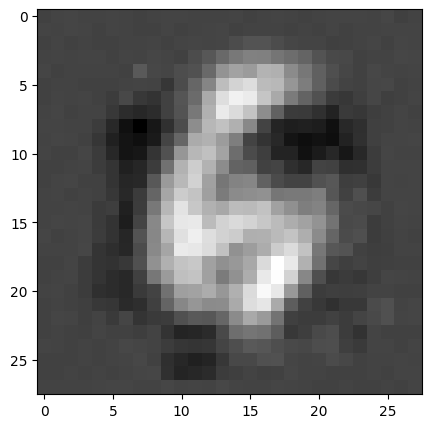

Epoch 10/10, Loss: 9.386472083861008e-05


In [18]:
train(10)

In [17]:
from torchview import draw_graph

model_graph = draw_graph(my_network(df["tensor"][0].size()[0], 10), input_size=df["tensor"][0].size(), expand_nested=True)
model_graph.visual_graph.render("./model_graph", cleanup=True, format='png')

'model_graph.png'